## Libraries

In [71]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import sys
import random as rn
import matplotlib.pyplot as plt
import sys
import pandas as pd
from sklearn.decomposition import PCA
from pathlib import Path
from settings import (SPEED_DATA_PATH, 
                      WIND_DATA_PATH, GEO_PATH)
from compress.sprintz_encode import compress_sprintz, get_sprintz_memory, decompress_sprintz
from compress.bypass import spatial_clustering, geo_sort, get_corr_lists
from compress.general_functions import get_memory_init, get_float_bytes
from compress.xor_encode import xor_compress_df, get_xor_memory_df, decompress_xor, decompress_xor_df
#from compress.xor_decode import decompress_xor, decompress_xor_df
from compress.lz4_encode import LZ4_compress_df, get_lz4_memory, LZ4_decompress_df
from compress.spatial_lz4 import spatial_clustering_PCA_LZ4, spatial_lz4_decompress
from compress.spatial_xor import spatial_clustering_xor, spatial_XOR_decompress
from compress.spatial_sprintz import spatial_clustering_sprintz, spatial_sprintz_decompress
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

## Params

In [2]:
table_params = [{
                'selector': 'caption',
                'props': [
                    ('color', 'Blue'),
                    ('font-size', '16pt'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('caption-side', 'top'),
                    ('padding', '10px')
                ]
            },
            {
                'selector': 'th',
                'props': [('font-size', '14pt')]
            }]

## Data

In [3]:
# int time series
speed_init = pd.read_csv(SPEED_DATA_PATH, parse_dates=[0], index_col=[0])# данные заполненности дорог
speed_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-08-31 18:22:00 to 2015-09-17 16:24:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2500 non-null   int64
dtypes: int64(1)
memory usage: 39.1 KB


In [4]:
speed_init['index'] = np.arange(speed_init.shape[0])
sensor_data = {}

for i in range(5):
    sensor_data[f'sensor_{i+1}'] = speed_init.loc[speed_init['index'] % 5 == i,
                                             ['value']]['value'].to_list()

df_speed = pd.DataFrame(sensor_data)
print('DataFrame shape:', df_speed.shape)
df_speed.head()

DataFrame shape: (500, 5)


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,90,80,84,94,90
1,91,62,96,75,84
2,86,93,69,88,71
3,74,68,88,71,87
4,82,68,73,69,57


In [5]:
df_speed.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,82.126000,81.538000,81.862000,81.786000,82.222000
std,8.404963,9.247897,8.155488,8.913085,8.983659
min,43.000000,28.000000,53.000000,29.000000,20.000000
25%,77.000000,76.000000,77.000000,76.000000,77.000000
50%,83.000000,82.000000,82.000000,82.000000,83.000000
75%,87.000000,88.000000,87.000000,88.000000,88.000000
max,109.000000,103.000000,106.000000,106.000000,105.000000


In [6]:
corr_speed = df_speed.corr()
styled_corr_speed = corr_speed.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# Отображение матрицы корреляции
display(styled_corr_speed)

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_1,1.000000,0.216599,0.170231,0.160731,0.129970
sensor_2,0.216599,1.000000,0.238876,0.241704,0.254247
sensor_3,0.170231,0.238876,1.000000,0.342827,0.135786
sensor_4,0.160731,0.241704,0.342827,1.000000,0.326703
sensor_5,0.129970,0.254247,0.135786,0.326703,1.000000


In [7]:
df_wind_init = pd.read_csv(WIND_DATA_PATH)
df_wind_init.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262968 entries, 0 to 262967
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AT      262968 non-null  float64
 1   BE      262968 non-null  float64
 2   BG      262968 non-null  float64
 3   CH      262968 non-null  float64
 4   CY      262968 non-null  int64  
 5   CZ      262968 non-null  float64
 6   DE      262968 non-null  float64
 7   DK      262968 non-null  float64
 8   EE      262968 non-null  float64
 9   ES      262968 non-null  float64
 10  FI      262968 non-null  float64
 11  FR      262968 non-null  float64
 12  EL      262968 non-null  float64
 13  HR      262968 non-null  float64
 14  HU      262968 non-null  float64
 15  IE      262968 non-null  float64
 16  IT      262968 non-null  float64
 17  LT      262968 non-null  float64
 18  LU      262968 non-null  float64
 19  LV      262968 non-null  float64
 20  NL      262968 non-null  float64
 21  NO      26

Возьмем данные о первых шести ветренных вышек.

In [8]:
df_wind = df_wind_init[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']]
df_wind = df_wind.head(10000)

Видим, что данные ненулевые через определенные промежутки времени. Это связано с тем, что отсутствует непрерывность замеров данных. Оставим только те строки, где есть хотя бы одно ненулевое значение.

In [9]:
# Ensure the correct columns are used
df_wind = df_wind.loc[(
    df_wind[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']] != 0).any(axis=1)].reset_index(drop=True)
df_wind.columns = [f'sensor_{i}' for i in range(df_wind.shape[1])]
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_1  5371 non-null   float64
 2   sensor_2  5371 non-null   float64
 3   sensor_3  5371 non-null   float64
 4   sensor_4  5371 non-null   float64
 5   sensor_5  5371 non-null   float64
dtypes: float64(6)
memory usage: 251.9 KB


## Data analisys

In [10]:
corr_wind = df_wind.corr()
styled_corr_wind = corr_wind.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# Отображение матрицы корреляции
display(styled_corr_wind)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_0,1.000000,0.692844,0.718031,0.858738,0.901123,0.844601
sensor_1,0.692844,1.000000,0.533855,0.723919,0.705373,0.862921
sensor_2,0.718031,0.533855,1.000000,0.637662,0.685302,0.661292
sensor_3,0.858738,0.723919,0.637662,1.000000,0.772007,0.839008
sensor_4,0.901123,0.705373,0.685302,0.772007,1.000000,0.884198
sensor_5,0.844601,0.862921,0.661292,0.839008,0.884198,1.000000


### Распределение

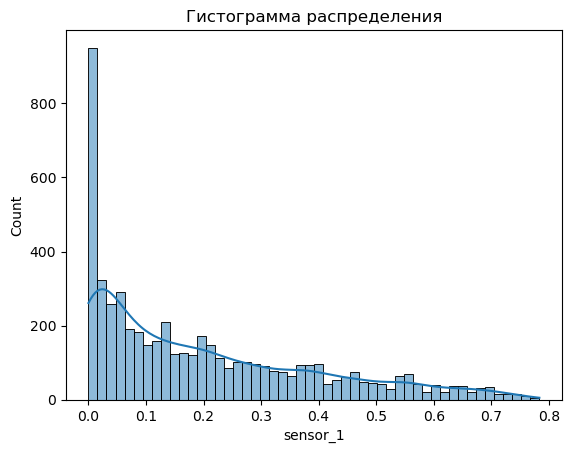

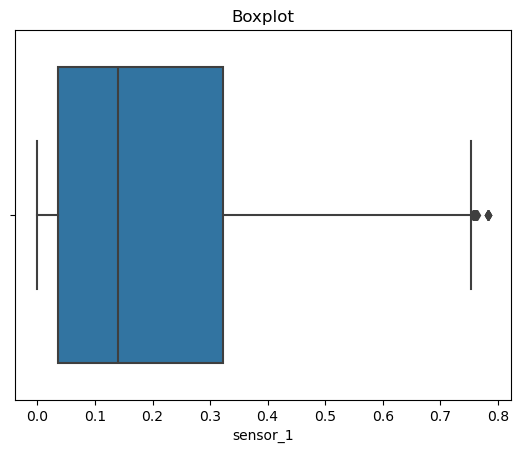

In [11]:
# Гистограмма + KDE
data = df_wind['sensor_1']
sns.histplot(data, kde=True, bins=50)
plt.title("Гистограмма распределения")
plt.show()

# Boxplot
sns.boxplot(x=data)
plt.title("Boxplot")
plt.show()

In [12]:
from scipy.stats import skew, kurtosis

skewness = skew(data)
kurt = kurtosis(data)

print(f"Асимметрия: {skewness:.2f}")
print(f"Эксцесс: {kurt:.2f}")

Асимметрия: 0.95
Эксцесс: -0.05


In [13]:
from scipy.stats import shapiro, normaltest

# Шапиро-Уилк (работает для небольших выборок < 5000)
stat, p = shapiro(data)
print(f"Шапиро-Уилк p-value: {p:.5f}")

# D’Agostino’s K-squared (для больших выборок)
stat, p = normaltest(data)
print(f"D’Agostino p-value: {p:.5f}")

Шапиро-Уилк p-value: 0.00000
D’Agostino p-value: 0.00000


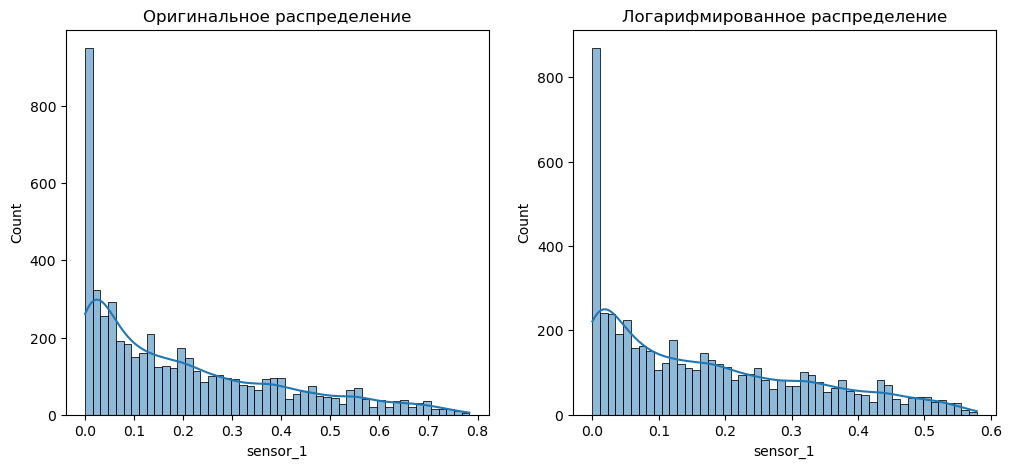

In [14]:
data_log = np.log1p(data)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data, kde=True, bins=50, ax=axes[0])
axes[0].set_title("Оригинальное распределение")

sns.histplot(data_log, kde=True, bins=50, ax=axes[1])
axes[1].set_title("Логарифмированное распределение")

plt.show()

### Шум

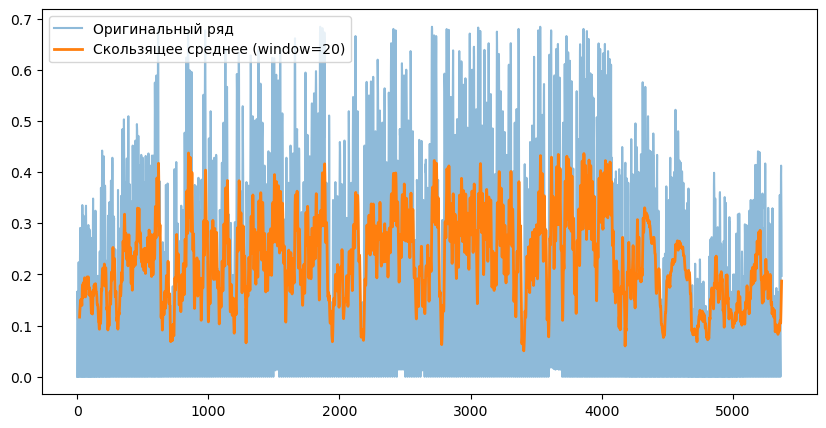

In [15]:
rolling_mean = df_wind.sensor_0.rolling(window=20).mean()

plt.figure(figsize=(10,5))
plt.plot(df_wind.sensor_0.values, label="Оригинальный ряд", alpha=0.5)
plt.plot(rolling_mean, label="Скользящее среднее (window=20)", linewidth=2)
plt.legend()
plt.show()

In [16]:
X = df_wind.sensor_0.values

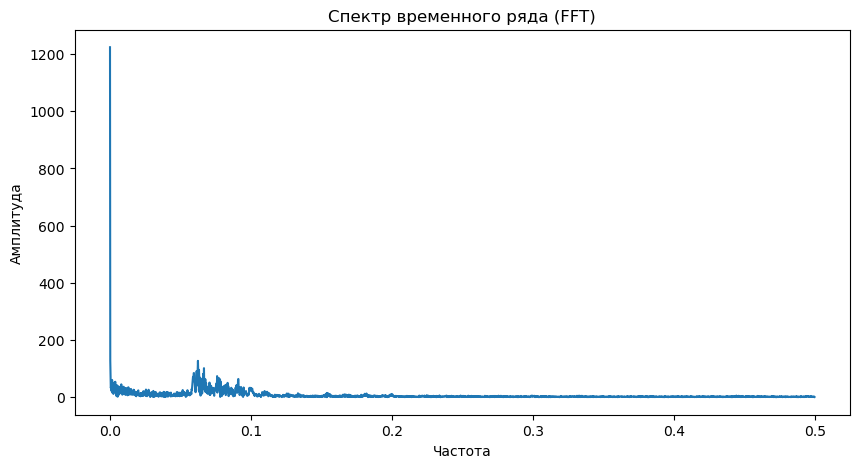

In [17]:
from scipy.fftpack import fft

X_fft = np.abs(fft(X))
freqs = np.fft.fftfreq(len(X))

plt.figure(figsize=(10,5))
plt.plot(freqs[:len(freqs)//2], X_fft[:len(X_fft)//2])
plt.title("Спектр временного ряда (FFT)")
plt.xlabel("Частота")
plt.ylabel("Амплитуда")
plt.show()

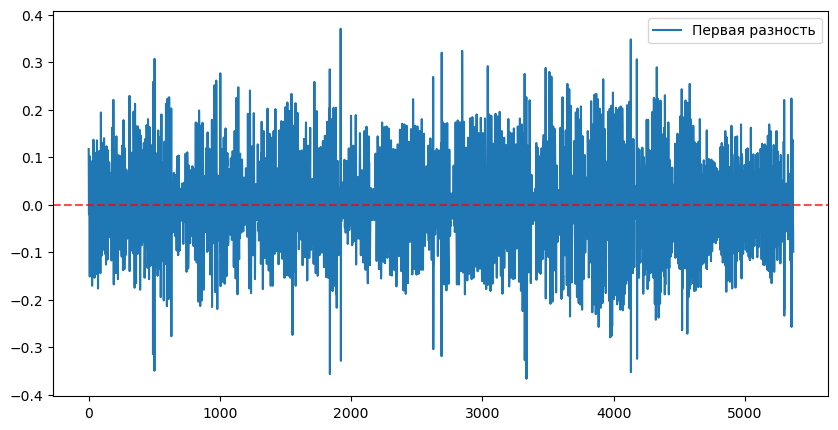

In [18]:
X_diff = np.diff(X)

plt.figure(figsize=(10,5))
plt.plot(X_diff, label="Первая разность")
plt.axhline(0, color='r', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [19]:
from scipy.stats import entropy

hist, _ = np.histogram(X, bins=50)
ent = entropy(hist)

print(f"Энтропия ряда: {ent:.3f}")

Энтропия ряда: 3.685


In [20]:
import pywt

wavelet = 'haar'
coeffs = pywt.wavedec(X, wavelet, level=3)

# Оценим долю энергии в каждом уровне разложения
energy_levels = [np.sum(np.abs(c)**2) for c in coeffs]

print("Энергия коэффициентов на каждом уровне разложения:", energy_levels)

Энергия коэффициентов на каждом уровне разложения: [356.04758554508646, 65.73701276035354, 27.73028362734523, 9.927217631002883]


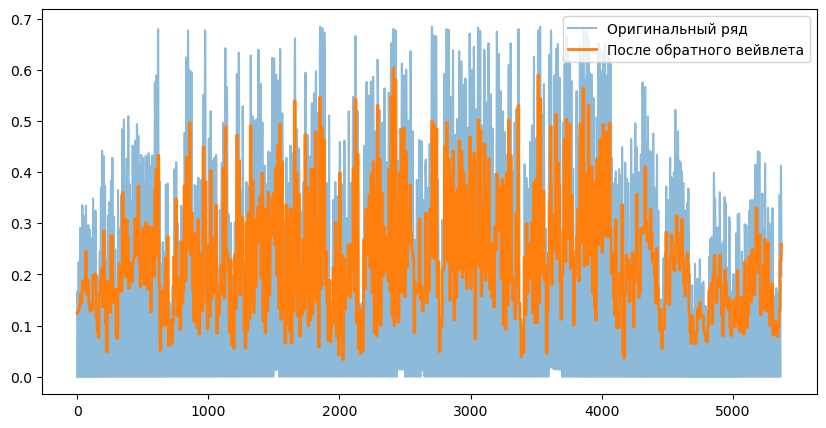

In [21]:
coeffs_filtered = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
X_restored = pywt.waverec(coeffs_filtered, wavelet)

plt.figure(figsize=(10,5))
plt.plot(X, label="Оригинальный ряд", alpha=0.5)
plt.plot(X_restored, label="После обратного вейвлета", linewidth=2)
plt.legend()
plt.show()

## Create or download geo_dict

In [22]:
def get_geo_dict(df):
    # make geo data
    sen_num = df.shape[1]
    x_y = []
    for i in range(sen_num):
        x_y.append([rn.uniform(.0, 6.0), rn.uniform(.0, 6.0)])
        print(f'sensor_{i}:', x_y[i])
    plt.grid(True)
    for i in range(len(x_y)):
        plt.plot(x_y[i][0], x_y[i][1], 'o', label = i)
        plt.legend(loc = 'best', fancybox = True, shadow = True)
    plt.plot(3*np.ones(300), np.arange(0, 6, 0.02))
    plt.plot(np.arange(0, 6, 0.02), 3*np.ones(300))
    geo_dict = dict(zip(df.columns, x_y))
    print(geo_dict)
    return dict(zip(df.columns, x_y))

sensor_0: [3.0024059140847044, 1.09447602165805]
sensor_1: [2.7401398972295876, 0.9170902164641501]
sensor_2: [0.036554261497981466, 1.18264348584897]
sensor_3: [4.079142757862404, 5.297768984949039]
sensor_4: [2.622322482823791, 2.665983667292534]
{'sensor_1': [3.0024059140847044, 1.09447602165805], 'sensor_2': [2.7401398972295876, 0.9170902164641501], 'sensor_3': [0.036554261497981466, 1.18264348584897], 'sensor_4': [4.079142757862404, 5.297768984949039], 'sensor_5': [2.622322482823791, 2.665983667292534]}


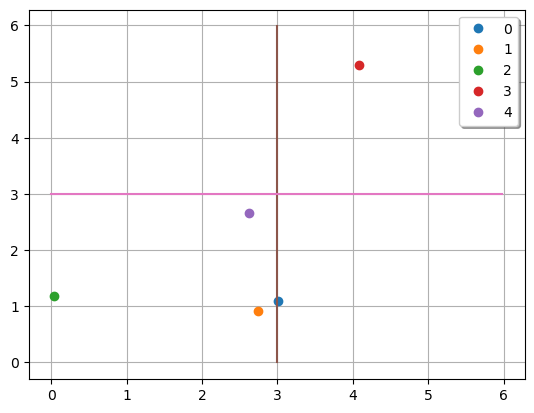

In [23]:
speed_geo_dict = get_geo_dict(df_speed)

In [24]:
display(styled_corr_wind)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_0,1.000000,0.692844,0.718031,0.858738,0.901123,0.844601
sensor_1,0.692844,1.000000,0.533855,0.723919,0.705373,0.862921
sensor_2,0.718031,0.533855,1.000000,0.637662,0.685302,0.661292
sensor_3,0.858738,0.723919,0.637662,1.000000,0.772007,0.839008
sensor_4,0.901123,0.705373,0.685302,0.772007,1.000000,0.884198
sensor_5,0.844601,0.862921,0.661292,0.839008,0.884198,1.000000


In [25]:
#for best clustering
d = {'sensor_0': [1.1, 4.2],
     'sensor_1': [3.2, 1.9],
     'sensor_2': [3.8, 2.6],
     'sensor_3': [0.51, 4.9],
     'sensor_4': [1.2, 3.1],
     'sensor_5': [2.12, 3.9],
     'sensor_6': [0.8, 1.2],
     'sensor_7': [1.3, 0.9],}

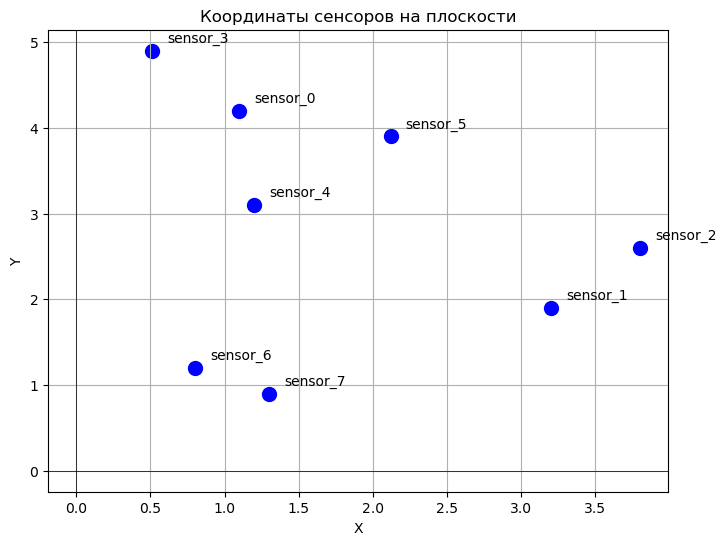

In [26]:
# Разделяем координаты
x_coords = [coord[0] for coord in d.values()]  # Координаты X
y_coords = [coord[1] for coord in d.values()]  # Координаты Y
labels = list(d.keys())  # Метки (названия сенсоров)

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, color='blue', s=100)  # Точки на плоскости

# Добавляем подписи к точкам
for i, label in enumerate(labels):
    plt.text(x_coords[i] + 0.1, y_coords[i] + 0.1, label, fontsize=10)

# Настройка графика
plt.title('Координаты сенсоров на плоскости')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # Линия X=0
plt.axvline(0, color='black', linewidth=0.5)  # Линия Y=0
plt.show()

In [27]:
spatial_clustering(df_wind, d)

{'sensor_0': ['sensor_0', 'sensor_3', 'sensor_5', 'sensor_4'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2']}

sensor_0: [5.239540833575115, 4.611961816733714]
sensor_1: [1.9068345542823033, 3.616034585598567]
sensor_2: [2.9868043397914192, 0.7684876834455949]
sensor_3: [0.06206337062424727, 0.42522800122628146]
sensor_4: [2.2466223663677183, 2.983715120881775]
sensor_5: [1.06441780307689, 1.3568510992794975]
{'sensor_0': [5.239540833575115, 4.611961816733714], 'sensor_1': [1.9068345542823033, 3.616034585598567], 'sensor_2': [2.9868043397914192, 0.7684876834455949], 'sensor_3': [0.06206337062424727, 0.42522800122628146], 'sensor_4': [2.2466223663677183, 2.983715120881775], 'sensor_5': [1.06441780307689, 1.3568510992794975]}


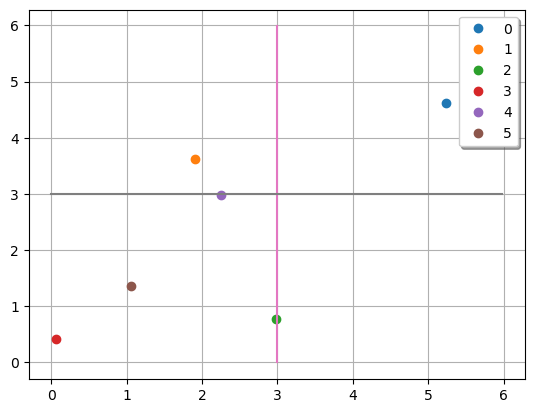

In [28]:
wind_geo_dict = get_geo_dict(df_wind)

In [29]:
print('Clusters for Emhires dataset:')
spatial_clustering(df_wind, wind_geo_dict)

Clusters for Emhires dataset:


{'sensor_0': ['sensor_0', 'sensor_4'],
 'sensor_1': ['sensor_1', 'sensor_5'],
 'sensor_2': ['sensor_2'],
 'sensor_3': ['sensor_3']}

In [31]:
import yaml

# Save wind_geo_dict to a YAML file
with open("geo_dicts/wind_geo_dict_1.yaml", "w") as file:
    yaml.dump(wind_geo_dict, file)

print("wind_geo_dict has been saved as wind_geo_dict.yaml")

wind_geo_dict has been saved as wind_geo_dict.yaml


## Sprintz

In [32]:
speed_sprintz_res = compress_sprintz(df=df_speed, chunk_size=8)
speed_sprintz_res

[[['10110100', '10100000', '10101000', '10111100', '10110100'],
  '11111011011011000000010000100100101110010000100110110110000010001100011111110110001000000101001111100010101011000110101100110011101000000001110001111100101011010100001000011010010010001011101001011011001100000111011110100100111010100'],
 [['10100100', '10110100', '10111000', '1111110', '10001010'],
  '1101101101101100011110100101010001100100001011010100011101001001000110000111100001100010000011001000001011001011000111011011101110010010001101101010010001010010000000001010000111000011100110000000000001000100001111101010010001'],
 [['10101110', '10100000', '10101110', '10010110', '10010110'],
  '1101101101101100100101010100000110001000100101101010000001011100010011010010010001000100011001100010010011001010010010100101000100000100001110001110100100101011100111111000100111010010100110110011010010000110010001000101100000'],
 [['10110000', '10101010', '10111000', '10111100', '10111000'],
  '101110101110101010101000011111000100

In [33]:
df_speed

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,90,80,84,94,90
1,91,62,96,75,84
2,86,93,69,88,71
3,74,68,88,71,87
4,82,68,73,69,57
...,...,...,...,...,...
495,83,88,78,97,81
496,93,77,81,74,90
497,77,80,88,84,78
498,91,83,80,77,82


In [34]:
# Check for equals decodind and original data
decode_res = decompress_sprintz(speed_sprintz_res, chunk_size=7)
print('Check for decode:', df_speed.equals(decode_res))

Check for decode: True


In [35]:
get_memory_init(df_speed)
get_sprintz_memory(speed_sprintz_res)

Размер исходных данных: 17433 бит
Размер исходных данных: 2179 байт 

Память сжатых Sprintz данных: 15788 бит
Память сжатых Sprintz данных: 1973 байт 



## XOR

In [36]:
compressed_df = xor_compress_df(df_wind)
compressed_df

[['0',
  '110001011110111111110111110000100110101010110010010011100000110110010110101',
  '1000000001111011010111101110010001100000000101001001101100000001',
  '1000000000000111101101000101100000111111010011001000001011010011',
  '1000000000000111111001100011010001101101111010101011001100111101',
  '1000000000000110101011101110011010110011011100111111110101000011',
  '1000000000000010101100001111000101011000100000010110111011101010',
  '1000000001111101101001010111100101001110011011101011010001101010',
  '1000000001111111111100010010000101110101001100100011100111011001',
  '1011111111000011010101011001001001110000011011001101100001000000',
  '1011111110111010001000110001011010001110100000000010110111001101',
  '1000000001111100100111110100001011110001111101101010111011010100',
  '1000000000001010000110001110011101111010001010000110001010000000',
  '1000000000001100000000101001001010100010101101010001001010000011',
  '1000000000000001101001111110101111101100110110111010011011101001',
  

In [37]:
decompressed_df = decompress_xor_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [38]:
get_float_bytes(df_wind)
get_xor_memory_df(compressed_df)

Размер исходных данных: 2062464 бит
Размер исходных данных: 257808 байт 

Память сжатых XOR данных: 1995690 бит
Память сжатых XOR данных: 249461.25 байт


## LZ4

In [39]:
compressed_df = LZ4_compress_df(df_wind)
compressed_df

{'sensor_0': b'\x04"M\x18h@\xd8\xa7\x00\x00\x00\x00\x00\x00\x10\xf4N\x00\x00\x13\x00\x01\x00\xf0+\xb5lp\x92U\x13\xbe?\xb4\xf7d\xf2\xb1M\xc5?gu(\xcd\xe9\xf9\xc2?Z\xc6\xc2\xa0\xdd\x1f\xc5?\x19;\xb1\x13;\xb1\xc3?\xf3U0K\xca\x01\xc1?\x99\xe1^\x05\xb3\xa4\xbc?@\xd89\x00#\xc3?G\x00\xf3\x01\x00\xcd-\x80\x8e\x16#\xba?\x19\x83v\x7fT\xbc\xc6(\x00\x95\xcc?\x1a\xf3\xeb\xa7!\xa6\xc0@\x00\x84ND\xa3\xa8[\x00\xbd?0\x00uh2\xf9\xd8\xa6\xca\xbeH\x00u,)\x07D\x86{\xb5`\x00\xf5 \xb4?*^\xcbX\xc8?\xc0~\x1ab\nI\xcc?\x1a\xf8\x81\x1f\xf8\x81\xcf?\xa0\x12\xe4)A\x9e\xd2?\xd9\x0b\xbd\xd0\x0b\xbd\xd0?\x0c\x8cK\xe7.\xd7\xc5H\x00\xf5\x08\x17z\xa1\x17z\xa1\xb7?(\x03\x8c\x8dw]\xc3?&2\xdc\xab`\x96\xc4(\x00\x04\xc0\x00uA\x90\xa7\x04yJ\xc0\x90\x00u\x8d\xa2n\x01t\xb4\xb8H\x00\x90\'\xea\x16@G\x8b\xc1?\xe6\xf7\x00#\x1c\xd0 \x01\xf5\n\xd2?\xe5~<\xf5\xf8x\xd5?\xed\x94 O\t\xf2\xd4?\xb3\xcf\xb45\xfen\xce\x08\x00\x048\x01\x04 \x01\xf1\x12\xca\xaf\x9f\x86\x98B\xb2?\x81\x1b\xb9\x91\x1b\xb9\xc1?\'\xa7\xe7K\x04\\\xcd?\xa0\xb6\xc6\xdf\

In [40]:
decompressed_df = LZ4_decompress_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [41]:
get_lz4_memory(compressed_df)
get_float_bytes(df_wind)

Размер сжатых данных: 191643 байт 

Размер исходных данных: 2062464 бит
Размер исходных данных: 257808 байт 



## Spatial + XOR

In [42]:
#todo solve problems where dif
df = df_wind.round(15)

In [43]:
res = spatial_clustering_xor(df, d)
res

{'sensor_0': {'sensor_0': ['0',
   '110001011110111111110111110000100110101010110010010011100000110110010110101',
   '1000000001111011010111101110010001100000000101001001101100000001',
   '1000000000000111101101000101100000111111010011001000001011010011',
   '1000000000000111111001100011010001101101111010101011001100111101',
   '1000000000000110101011101110011010110011011100111111110101000011',
   '1000000000000010101100001111000101011000100000010110111011101010',
   '1000000001111101101001010111100101001110011011101011010001101010',
   '1000000001111111111100010010000101110101001100100011100111011001',
   '1011111111000011010101011001001001110000011011001101100001000000',
   '1011111110111010001000110001011010001110100000000010110111001101',
   '1000000001111100100111110100001011110001111101101010111011010100',
   '1000000000001010000110001110011101111010001010000110001010000000',
   '1000000000001100000000101001001010100010101101010001001010000011',
   '100000000000000110100111111010

In [44]:
decompressed_df = spatial_XOR_decompress(res)
print('Check for decode:', decompressed_df.equals(df))

Check for decode: True


In [45]:
get_float_bytes(df)

total = 0
keys_res = res.keys()
for key in keys_res:
    keys_clust = res[key].keys()
    for k in keys_clust:
        for l in res[key][k]:
            total+=len(l)

print('Объем сжатых данных(бит):', total)
print('Объем сжатых данных(байт):', total//8)

Размер исходных данных: 2062464 бит
Размер исходных данных: 257808 байт 

Объем сжатых данных(бит): 2045253
Объем сжатых данных(байт): 255656


## Spatial + Sprintz

In [46]:
df = df_wind*100
df = df.astype(int)

In [47]:
res = spatial_clustering_sprintz(df.copy(),d, 0.7)
res

{'sensor_0': [[['0', '0', '0', '0'],
   '10110110110000001011001010000110010000001000110001101010001111000100111000010011000010101000000001011001010000100010001001010000101011001000110100100'],
  [['11110', '100', '11000', '11010'],
   '1011101011010000111011010001110010101000100000000110000110010000000110000001010010001010000011011110010000000011001101000000000111001010100000000100000110010000001'],
  [['10100', '11111', '1000', '1100'],
   '10110110010100000010010111100000111001000001100010011010001100000110011011110001100110100011111100000000010111001000110100010011000010001100100101111'],
  [['111010', '10011', '10010', '1'],
   '110100101101000000010101000110000101001000110000001000001011000110001001101101110110010100000011101010111000000000000000001110011101100101000001000011000010'],
  [['11110', '11111', '1100', '1110'],
   '1011001011000000001010001100001100011101011000010000110001011101010011010110111000110000000010010011011010000001100111000101000111011001001010'],
  [['1000

In [48]:
clust_dict = spatial_clustering(df, d, 0.7)
decode_res = spatial_sprintz_decompress(res, clust_dict)
print('Check for decode:', df.equals(decode_res))

Check for decode: False


In [49]:
def get_lz4_memory(compressed_df):
    memory = 0
    for col in compressed_df:
        memory += len(compressed_df[col])
    print(f'Размер сжатых данных: {memory} байт', '\n')

In [50]:

res['sensor_0'][0]

[['0', '0', '0', '0'],
 '10110110110000001011001010000110010000001000110001101010001111000100111000010011000010101000000001011001010000100010001001010000101011001000110100100']

In [51]:
get_memory_init(df)
total = 0
res_keys = res.keys()
for k in res_keys:
    if len(res[k]) == 1:
        total += len(res[k][0])
    else:
        infb = 0
        for r in res[k]:
            infb+=len(''.join(r[0]))
            infb+=len(r[1])
        infb = infb//8
        total += infb
print(f'Размер сжатых данных: {total} байт', '\n')

Размер исходных данных: 131425 бит
Размер исходных данных: 16428 байт 

Размер сжатых данных: 42308 байт 



## Spatial + PCA + LZ4

In [52]:
def rmse(df1, df2):
    return round(np.sqrt(np.median((df1 - df2)**2)), 3)

def mse(df1, df2):
    return round(np.median((df1 - df2)**2), 3)

def mae(df1, df2):
    return ((df1 - df2) ** 2).mean().mean()

def total_error(df1, df2):
    return (df1 - df2).abs().sum().sum()

def column_error(df1, df2):
    return (df1 - df2).abs().sum(axis=0)

In [53]:
res = spatial_clustering_PCA_LZ4(df_wind, d)

In [54]:
res

{'sensor_0': [b'\x04"M\x18H@\xb0O\x01\x00\x00\x00\x00\x00c\xbd\xf2\x00\x00\xf2\x83\x08\x85h\xd1(\xcb\xda\xbf\xbal\x02d\xf1!\x9f?\x9e\x15\xac\xf1\xb9\xc8\xd1\xbf\xd5\xb1\xdc\x8b8\xf0\x98? \x06\x08\x17x+\xc4\xbf\xc7\x87\t\xc9*\x9cI\xbf\xb6\xa4 \xfdJ\xa5\xbc\xbf\xbd\x07\xdf\xcf\x9ef\xa9\xbfo\xc7\xb7\xe7\x9e\x90\x86\xbf\xa0\xc9\xad\x0f\x01d\xa8\xbfd-\xa8<\xa3\xc0\x94\xbfkF\xa6\xb6\x0e`\xab\xbf\xb7\xdaw\x93 \x80\xb9\xbf\x7f\x02\xc2\xde\xb4\xc6\xae\xbf8\xda\x0f\xb2+A\xc6\xbf\x8b)\x8a\x96\x14\x92\xae\xbf\xf2\xce\xb7G/\xc5\xcf\xbfE\x8fgg\xe5\x02\xaa\xbf\xf5\x84\x90\x00"\x89f\x90\x00\xfdp\x9bt~y[\xff\xd2\xbf\x80\xa4\xeb\xdbU\x00\x94?\xae\xfa\xd9\x1fa\xd8\xc2\xbf\xdb\x15=\x8c\xec\xa7\xf7\xbeM\xd1\x9b\xfb\xa9I\xb2\xbf\xdd\xba\xce\x13\xd3\x93\x8e\xbfc\xc39\xcf\x87S\xbb\xbf\xb9\x1a\x80}\xb7\xf7\xc4\xbf\xfc\x13\xf5\x84J\xbd\xba\xbf\xd6\xbe\xc7]g\xba\xc8\xbf\xf2\x0b\x9ao\x17\x05\xc0\xbf\xc6\xb0/n\x8fd\xc9\xbf\xb2\x00\x98e\x93\xfd\xc6\xbf\\\xfb\xca8zx\xc2\xbfU}\xfcb\xd6\x1b\xcf\xbf\xc7k@\xcb\x9b\xa8\x

In [55]:
len(res['sensor_0'][0]+res['sensor_0'][1])

81132

In [56]:
clusters = spatial_clustering(df_wind, d)
dec_res = spatial_lz4_decompress(res, clusters)

6


In [57]:
print('RMSE:', rmse(df_wind, dec_res))
print('MSE:', mse(df_wind, dec_res))
print('MAE:', mae(df_wind, dec_res))
print('Total error:', total_error(df_wind, dec_res))
print('Column error:\n', column_error(df_wind, dec_res))

RMSE: 0.005
MSE: 0.0
MAE: 0.0010792084202583805
Total error: 541.2244023274869
Column error:
 sensor_0    191.142023
sensor_1      0.000000
sensor_2      0.000000
sensor_3     61.528244
sensor_4     86.944538
sensor_5    201.609598
dtype: float64


In [58]:
get_float_bytes(df_wind)
total_bytes = sum(sys.getsizeof(v) for k in res.keys() for v in res[k])
print('Сжатое байт:', total_bytes)

Размер исходных данных: 2062464 бит
Размер исходных данных: 257808 байт 

Сжатое байт: 148894


## NN + SZ3

In [ ]:
def compress_pca(pca: PCA):
    pca_data = {
        "components": pca.components_.astype(np.float32),  # float32 вместо float64
        "mean": pca.mean_.astype(np.float32),
        "variance": pca.explained_variance_ratio_.astype(np.float32)
    }
    pca_bytes = pickle.dumps(pca_data)
    compressed_pca = lz4.frame.compress(pca_bytes)
    return compressed_pca


def LZ4_pca_compress(df_comp: pd.DataFrame):
    pca_n = max(2, int(0.5 * len(df_comp.columns)))
    pca = PCA(n_components=pca_n)  # Уменьшаем до 2 компонент
    transformed = pca.fit_transform(df_comp)
    compressed = lz4.frame.compress(transformed.tobytes())
    pca_compress = compress_pca(pca)
    return [compressed, pca_compress]


def lz4_one(arr):
    arr_bytes = arr.tobytes()
    compressed = lz4.frame.compress(arr_bytes)
    return compressed


def spatial_clustering_PCA_LZ4(df_init, x_y_dict, cor_lvl = 0.8):
    cl_sp = {}
    sensors = list(df_init.columns)
    iter_sen = sensors[0]
    while len(sensors)!=0:
        iter_clust = []
        sensors.remove(iter_sen)
        iter_clust.append(iter_sen)
        sen_queue = geo_sort(x_y_dict, sensors, iter_sen)
        if sen_queue:
            for sen in sen_queue:
                cor = get_corr_lists(df_init[iter_sen], df_init[sen])
                if cor>cor_lvl:
                    iter_clust.append(sen)
                    sensors.remove(sen)
                elif len(iter_clust)>1: 
                    cl_sp[iter_sen] = LZ4_pca_compress(df_init[iter_clust])
                    iter_sen = sen
                    break
                else:
                    dec_one = [lz4_one(df_init[iter_clust[0]].values), '']
                    cl_sp[iter_sen] = dec_one
                    iter_sen = sen
                    break
        else:
            arr = df_init[iter_sen].values
            arr_bytes = arr.tobytes()
            cl_sp[iter_sen] = [lz4.frame.compress(arr_bytes), '']
            break
    return cl_sp

In [62]:
df = df_wind[['sensor_0', 'sensor_3', 'sensor_4', 'sensor_5']].copy()
# Выбираем главный сенсор (первый столбец)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# Выбираем зависимые сенсоры (все кроме первого столбца)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

## SZ3

In [63]:
import numpy as np
from pathlib import Path
import sys
import pandas as pd
from sz.SZ3.tools.pysz.pysz import SZ

In [64]:
data = df.values.transpose()

In [65]:
get_float_bytes(df)

Размер исходных данных: 1374976 бит
Размер исходных данных: 171872 байт 



In [67]:
lib_extension = {
    "darwin": "libSZ3c.dylib",  # macOS
    "win32": "SZ3c.dll",  # Windows
}.get(sys.platform, "libSZ3c.so")  # Linux (по умолчанию)
lib_extension

'libSZ3c.dylib'

In [68]:
sz = SZ(f"/usr/local/lib/{lib_extension}")

In [72]:
mem = 0
data_dec = []
for d in data:
    data_cmpr, cmpr_ratio = sz.compress(d, eb_mode=0, eb_pwr=0, eb_rel=0, eb_abs=0.03)
    print(data_cmpr.nbytes)
    data_dec.append(sz.decompress(data_cmpr, d.shape, d.dtype))
    mem += data_cmpr.nbytes
    print(mean_squared_error(d, sz.decompress(data_cmpr, d.shape, d.dtype)))
print(mem)

2082
0.0002766918524623217
2145
0.00026444352170291183
2129
0.00027273231822622947
1867
0.00028175398323767334
8223


In [73]:
print(round(mean_squared_error(data, data_dec), 6))

0.000274


In [ ]:
# сжатие всего кластера сразу
data_cmpr, cmpr_ratio = sz.compress(data, eb_mode=0, eb_pwr=0, eb_rel=0, eb_abs=0.01)
print(f"Compression ratio: {cmpr_ratio}")

Compression ratio: 14.752961373390558


In [192]:
size_in_bytes = data_cmpr.nbytes
print(f"Объем массива: {size_in_bytes} байт")

Объем массива: 25525 байт


In [76]:
data_dec = sz.decompress(data_cmpr, data.shape, data.dtype)
sz.verify(data, data_dec)

abs err=0.0099995


(0.009999500034394062, 43.01945279354077, 0.007063620532974902)

## SZ + Conv

### Best

In [79]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, SeparableConv1D
from tensorflow.keras.models import Model
import lz4.frame
X = main_sensor.reshape(-1, 1)  # Вход автоэнкодера
Y = dependent_sensors
# Гиперпараметры
window_size = 64
X_windows = []
Y_targets = []
output_dim = Y.shape[1]
for i in range(len(X) - window_size):
    X_windows.append(X[i:i+window_size])
    Y_targets.append(Y[i+window_size]) 

X_windows = np.array(X_windows).reshape(-1, window_size, 1)
Y_targets = np.array(Y_targets).reshape(-1, output_dim)

X_windows = np.array(X_windows).reshape(-1, window_size, 1)
Y_targets = np.array(Y_targets).reshape(-1, output_dim)
output_dim = Y.shape[1]

inputs = Input(shape=(window_size, 1))
x = SeparableConv1D(2, kernel_size=3, activation='selu', padding='same')(inputs)  # Глубинная свёртка
x = Flatten()(x)
x = Dense(4, activation='selu')(x)  
outputs = Dense(output_dim, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

model.fit(X_windows, Y_targets, epochs=50, batch_size=64, verbose=1)

preds = model.predict(X_windows)
for i in range(output_dim):
    rmse = mean_squared_error(Y_targets[:, i], preds[:, i])
    print(f"RMSE sen_{i+3}: {rmse:.6f}")

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0506
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0174
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115
Epoch 16/50
83/83 ━

In [82]:
# Сохраняем модель в формате SavedModel
model.export("saved_model")  # Сохраняется в папку

# Загружаем и конвертируем в tflite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
#converter.target_spec.supported_types = [tf.float32]  # Без квантизации
tflite_model = converter.convert()

# Сохраняем tflite
with open("models/model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5649740928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649741104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649742160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649741456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649742864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649742336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649741808: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1743923944.655703 9988840 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1743923944.655846 9988840 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-04-06 10:19:04.656521: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-06 10:19:04.658783: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-06 10:19:04.658816: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-06 10:19:04.695530: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-06 10:19:04.786992: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-06 10:19:04.831699: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 175199 microseconds.


In [83]:
import lz4.frame

# Чтение и сжатие модели
with open("models/model.tflite", "rb") as f:
    tflite_bytes = f.read()
    compressed_model = lz4.frame.compress(tflite_bytes)

# Сохраняем сжатую модель
with open("models/model.tflite.lz4", "wb") as f:
    f.write(compressed_model)

print(f"📦 Размер после сжатия: {len(compressed_model)} байт")

📦 Размер после сжатия: 5354 байт


In [85]:
# Распаковка обратно
with open("models/model.tflite.lz4", "rb") as f:
    compressed_data = f.read()
    decompressed_tflite = lz4.frame.decompress(compressed_data)

# Загрузка в TFLite-интерпретатор
interpreter = tf.lite.Interpreter(model_content=decompressed_tflite)
interpreter.allocate_tensors()

# Получение инфо
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [86]:
restored_Y = []

for i in range(len(X_windows)):
    input_tensor = X_windows[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    restored_Y.append(output[0])

restored_Y = np.array(restored_Y)

In [87]:
for i in range(output_dim):
    rmse = mean_squared_error(Y[window_size:, i], restored_Y[:, i])
    print(f"MSE sen_{i+3}: {rmse:.6f}")

MSE sen_3: 0.009829
MSE sen_4: 0.009888
MSE sen_5: 0.007035
